In [1]:
import os
import pickle
import numpy as np
import pysnooper
import random
import copy
import tqdm
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def truncated_normal(mean=0.5, sd=0.1, low=0.0, upp=0.8):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [3]:
# define a class of a Bernoulli arm / Coin 
class Bernoulli_Arm:
    '''
    The class of an arm whose reward follows a Bernoulli distribution (aka a coin)
    ----- Parameters -----
    # p: the probability for the arm to give a reward
    ----- Methods ----
    # pull(): make an arm pull; return the reward
    # batch_pull(num_pull): make *num_pull* times of arm pulls  
    '''

    def __init__(self, p=None, random_mean = 'uniform'):
        '''
        :param p: the probability for the arm to give a reward (bias of a coin)
        '''
        if p is not None:
            self.p = p
        elif random_mean=='uniform':
            self.p = np.random.uniform()
        elif random_mean=='gaussian':
            truc_gaussian_sampler = truncated_normal()
            self.p = truc_gaussian_sampler.rvs()
        else:
            raise ValueError('Distribution of the mean not recognized!')

    def pull(self):
        '''
        make an arm pull by rejection sampling
        '''
        this_sample = np.random.uniform()
        
        if this_sample<=self.p:
            return 1.0
        else:
            return 0.0
        
    def batch_pull(self, num_pull):
        '''
        make *num_pull* times of arm pulls, return the average
        '''
        
        if num_pull<=1e5:
            # use vectorized operations to speed up
            vec_sample = np.random.uniform(size=[(int)(num_pull)])
            # implementation: p subtract vec_sample is either >=0 or <0, same as rejection sampling
            # taking the ceiling tells us how many pulls gives reward
            # take the average of the rewards
            # add 1e-20 so that the reward will not round to -1
        
            return np.average(np.ceil(self.p - vec_sample + 1e-20))
        else:
            # sampling a gaussian noise to approximate
            return self.p + np.random.normal(0, 2/np.sqrt(num_pull))

In [4]:
# We need to code a coin-feeding buffer to simulate the `bank'
# such that inside the algorithms it truly simulates a `local memory'
class Arm_Reading_Buffer:
    '''
    The class to read arms one after another -- simulating the 'bank' that feeds the stream with arms
    ----- Parameters -----
    # arm_set: the set of arms. supported type numpy array
    # n: number of arms in the set
    # best_arm: the index of the best arm
    # Delta: the gap between the best and the second-best arm
    ----- Methods ----
    # read_next_arm(): read the next arm and move the index +1
    '''
    
    def __init__(self, arm_set):
        '''
        :param arm_set: the set of arms. supported type numpy array
        '''
        if type(arm_set) is not np.ndarray:
            raise ValueError('Expecting numpy array of arms. Please convert')
        # flatten the array if it's not already
        self.arm_set = np.reshape(arm_set, [-1])
        # number of arms
        self.n = np.shape(self.arm_set)[0]
        # collect the reward parameters
        list_rewards = []
        for arm in self.arm_set:
            list_rewards.append(arm.p)
        array_rewards = np.array(list_rewards)
        # sort and find the indices for best and second-best arms
        sorted_indices = np.argsort(-array_rewards)
        self._best_index = sorted_indices[0]
        self._runner_up_index = sorted_indices[1]
        # collect the best arms -- information withholding from the algorithm
        self._best_arm = self.arm_set[self._best_index]
        self._runner_up_arm = self.arm_set[self._runner_up_index]
        self._best_reward = array_rewards[self._best_index]
        self._runner_up_reward = array_rewards[self._runner_up_index]
        # the gap is supposed to be known
        self.Delta = self._best_reward - self._runner_up_reward
        # the sub-exponential gaps as the budget
        self._Delta_list = (self._best_reward - array_rewards[sorted_indices])[1:]
        self.H2 = np.sum((1/np.square(self._Delta_list)) * np.log(np.log(1/self._Delta_list)))
        # the internal index
        self._current_arm_ind = 0
        self._terminate_flag = False
        # maintain a counter for the regret
        self.regret_counter = 0
        

    def read_next_arm(self):
        '''
        Read the next arm, and increase the index by 1
        '''
        if not self._terminate_flag:
            # read the current arm
            return_arm = self.arm_set[self._current_arm_ind]
            if (self._current_arm_ind == self.n - 1):
                self._terminate_flag = True
            # increase the index by 1
            self._current_arm_ind = self._current_arm_ind + 1
            
            return return_arm
        else:
            # stream at the end
            return None
    
    def reset(self):
        '''
        Reset the pointer and the termination flag so that one can reuse the stream
        '''
        self._current_arm_ind = 0
        self._terminate_flag = False
        self.regret_counter = 0
        
    def regret_eval(self, arm_reward, arm_pulls=1):
        '''
        Incur a cost of (best_reward - arm_reward)*arm_pulls
        '''
        
        self.regret_counter = self.regret_counter + (self._best_reward-arm_reward)*arm_pulls

In [5]:
# construct some arm examples
num_arms = 5000
arm_list = [Bernoulli_Arm(random_mean='gaussian') for _ in range(num_arms-1)]
arm_list.append(Bernoulli_Arm(p=0.82))
random.shuffle(arm_list)
# construct the buffer
streaming_arm_buffer = Arm_Reading_Buffer(arm_set = np.array(arm_list))

In [67]:
# the regret-minimization algorithm with the uniform exploration algorithm
def uniform_exploration_algorithm(arm_stream, T, verbose=True):
    '''
    :param arm_stream: the streaming buffer that `feeds' the arms
    :param T: the horizon of the number of trials
    :param verbose: flag to control whether to print information
    '''
    # read the number of arms -- neccessary for the naive algorithm
    num_arms = arm_stream.n
    # sample times for each arm -- the optimal number in uniform exploration
    batch_size = ((T/num_arms)**(2/3))*(np.log(T)**(1/3))
    # memory list 
    stored_arm = []
    buffer_arm = []
    # memory of the best reward
    stored_reward = 0
    # arm index 
    arm_ind = 0
    current_ind = 0
    # keep track of the total number of arm pulls
    total_arm_pulls = 0
    # batch size for arm pulling
    while(1):
        if verbose:
            print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
        if total_arm_pulls>=T:
            print('Trial budgets exhausted!')
            break
        # read the next arm
        if not stored_arm:
            # this only happens for the first arm
            stored_arm.append(arm_stream.read_next_arm())
            best_stored_reward = stored_arm[0].batch_pull(batch_size)
            total_arm_pulls = total_arm_pulls + batch_size
            arm_stream.regret_eval(stored_arm[0].p, batch_size)
        else:
            # read the arm to the 'buffer' for the extra arm
            current_arm = arm_stream.read_next_arm()
            current_ind = current_ind + 1
            if current_arm is None:
                # end of the stream
                break
            # If stream not ended, compare
            buffer_reward = current_arm.batch_pull(batch_size)
            total_arm_pulls = total_arm_pulls + batch_size
            arm_stream.regret_eval(current_arm.p, batch_size)
            if verbose:
                print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
            # replace the stored arm if it's beaten
            if stored_reward>=buffer_reward:
                continue
            else:
                stored_arm.append(current_arm)
                arm_ind = current_ind + 0
                stored_arm.pop(0)
                stored_reward = buffer_reward
                
    # pulling the arm that we commit to if there is any remaining trials
    remain_trial_nums = T - total_arm_pulls
    if remain_trial_nums>=0:
        arm_stream.regret_eval(stored_arm[0].p, remain_trial_nums)
    
    return stored_arm[0], arm_ind, arm_stream.regret_counter

In [68]:
# the regret-minimization algorithm with the native (n*log(n)/Delta^2) arm-pull eps-best arm algorithm
# @pysnooper.snoop()
def naive_eps_best_algorithm(arm_stream, T, verbose=True):
    '''
    :param arm_stream: the streaming buffer that `feeds' the arms
    :param T: the horizon of the number of trials
    '''
    # read the number of arms -- neccessary for the naive algorithm
    num_arms = arm_stream.n
    # set the eps parameter
    eps = ((num_arms/T)**(1/3))
    # sample times for each arm
    batch_size = np.log(num_arms)/(eps**2)
    # memory list 
    stored_arm = []
    buffer_arm = []
    # memory of the best reward
    stored_reward = 0
    # arm index 
    arm_ind = 0
    current_ind = 0
    # keep track of the total number of arm pulls
    total_arm_pulls = 0
    # batch size for arm pulling
    while(1):
        if verbose:
            print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
        if total_arm_pulls>=T:
            print('Trial budgets exhausted!')
            break
        # read the next arm
        if not stored_arm:
            # this only happens for the first arm
            stored_arm.append(arm_stream.read_next_arm())
            best_stored_reward = stored_arm[0].batch_pull(batch_size)
            total_arm_pulls = total_arm_pulls + batch_size
            arm_stream.regret_eval(stored_arm[0].p, batch_size)
        else:
            # read the arm to the 'buffer' for the extra arm
            current_arm = arm_stream.read_next_arm()
            current_ind = current_ind + 1
            if current_arm is None:
                # end of the stream
                break
            # If stream not ended, compare
            buffer_reward = current_arm.batch_pull(batch_size)
            total_arm_pulls = total_arm_pulls + batch_size
            arm_stream.regret_eval(current_arm.p, batch_size)
            if verbose:
                print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
            # replace the stored arm if it's beaten
            if stored_reward>=buffer_reward:
                continue
            else:
                stored_arm.append(current_arm)
                arm_ind = current_ind + 0
                stored_arm.pop(0)
                stored_reward = buffer_reward
                
    # pulling the arm that we commit to if there is any remaining trials
    remain_trial_nums = T - total_arm_pulls
    if remain_trial_nums>=0:
        arm_stream.regret_eval(stored_arm[0].p, remain_trial_nums)
    
    return stored_arm[0], arm_ind, arm_stream.regret_counter

In [69]:
def best_among_remaining(arm_stream, arm_list, num_pull):
    '''
    :param arm_stream: the streaming buffer that `feeds' the arms
    :param arm_list: list of arms, expect length to be equal to the number of levels, 
                        and each level contains a single arm
    :param num_pull: the number of arm pulls on each level
    '''
    best_arm_level = 0
    best_emp_reward = 0
    for level in range(len(arm_list)):
        if arm_list[level]:
            current_emp_reward = arm_list[level][0].batch_pull(num_pull)
            arm_stream.regret_eval(arm_list[level][0].p, num_pull)
            if current_emp_reward>best_emp_reward:
                best_arm_level = level
    
    return best_arm_level 

In [70]:
# the regret-minimization algorithm with the O(log(n)) space
# @pysnooper.snoop()
def log_eps_best_algorithm(arm_stream, T, verbose=True):
    '''
    :param arm_stream: the streaming buffer that `feeds' the arms
    :param T: the horizon of the number of trials
    '''
    # read the number of arms -- necessary for the regret-minimization problem
    num_arms = arm_stream.n
    # set the eps parameter
    eps = ((num_arms/T)**(1/3))
    # determine the levels of the tower -- we will discard at a rate of 4 so log_e is definitely enough
    num_levels = (int)(np.log(num_arms))
    # memory list -- every level keeps an empty list in the begining
    levels_stored_arms = []
    for level in range(num_levels):
        levels_stored_arms.append([])
    buffer_arm = []
    # batch size of each level
    levels_batch_size = []
    for level in range(num_levels):
        levels_batch_size.append(np.ceil(1.2**(level)*(1/eps**2)))
    # sample complexity on each level
    levels_sample_caps = []
    for level in range(num_levels):
        levels_sample_caps.append(np.ceil(6*levels_batch_size[level]))
    # memory of the best reward
    levels_stored_reward = [0]*num_levels
    # arm index 
    arm_ind = 0
    current_ind = 0
    # keep track of the total number of arm pulls
    total_arm_pulls = 0
    level_arm_pulls = [0]*num_levels
    # count the number of level the algorithm ever reached
    max_level = 0
    # batch size for arm pulling
    while(1):
        if verbose:
            print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
        for level in range(num_levels):
            if max_level<level:
                max_level = level
            # first check if the level budget is exhausted
            if level_arm_pulls[level]<=levels_sample_caps[level]:
                # if not --> ordinary operations, and break and for loop afterwards
                # read the next arm
                if not levels_stored_arms[level]:
                    # this happens for the first arm or the first level is 'cleared'
                    # will only happen to the first level
                    current_arm = arm_stream.read_next_arm()
                    # if no next arm then terminate, run the remaining trials and return
                    if current_arm is None:
                        remain_trial_nums = T - total_arm_pulls
                        if remain_trial_nums>=max_level*levels_batch_size[0]:
                            best_arm_level = best_among_remaining(arm_stream, 
                                                                  levels_stored_arms, 
                                                                  levels_batch_size[0])
                            remain_trial_nums = remain_trial_nums - max_level*levels_batch_size[0]
                        else:
                            best_arm_level = max_level
                        if remain_trial_nums>=0:
                            arm_stream.regret_eval(levels_stored_arms[best_arm_level][0].p, remain_trial_nums)
                            
                        return levels_stored_arms[best_arm_level][0], arm_ind, arm_stream.regret_counter
                    # else proceed as normal
                    levels_stored_arms[level].append(current_arm)
                    buffer_reward = current_arm.batch_pull(levels_batch_size[level])
                    if buffer_reward>levels_stored_reward[level]:
                        levels_stored_reward[level] = buffer_reward
                    total_arm_pulls = total_arm_pulls + levels_batch_size[level]
                    level_arm_pulls[level] = level_arm_pulls[level] + levels_batch_size[level]
                    arm_stream.regret_eval(levels_stored_arms[level][0].p, 
                                           levels_batch_size[level])
                else:
                    # read the arm to the 'buffer' for the extra arm
                    if level == 0:
                        current_arm = arm_stream.read_next_arm()
                        # if no next arm then terminate, run the remaining trials and return
                        if current_arm is None:
                            remain_trial_nums = T - total_arm_pulls
                            if remain_trial_nums>=max_level*levels_batch_size[0]:
                                best_arm_level = best_among_remaining(arm_stream, 
                                                                      levels_stored_arms, 
                                                                      levels_batch_size[0])
                                remain_trial_nums = remain_trial_nums - max_level*levels_batch_size[0]
                            else:
                                best_arm_level = max_level
                            if remain_trial_nums>=0:
                                arm_stream.regret_eval(levels_stored_arms[best_arm_level][0].p, remain_trial_nums)
                                
                            return levels_stored_arms[best_arm_level][0], arm_ind, arm_stream.regret_counter
                    else:
                        if len(levels_stored_arms[level])>1:
                            current_arm = levels_stored_arms[level][-1]
                            levels_stored_arms[level].pop(-1)
                        else:
                            # if there's only one arm in this level -- record the level empirical reward first
                            levels_stored_reward[level] = levels_stored_arms[level][0].batch_pull(levels_batch_size[level])
                            arm_stream.regret_eval(levels_stored_arms[level][0].p, levels_batch_size[level])
                            break
                    # compare the current arm with the benchmark of the current level
                    buffer_reward = current_arm.batch_pull(levels_batch_size[level])
                    total_arm_pulls = total_arm_pulls + levels_batch_size[level]
                    level_arm_pulls[level] = level_arm_pulls[level] + levels_batch_size[level]
                    arm_stream.regret_eval(levels_stored_arms[level][0].p, levels_batch_size[level])
                    if level == 0:
                        current_ind = current_ind + 1
                        if verbose:
                            print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
                    # replace the stored arm if it's beaten
                    if levels_stored_reward[level]>=buffer_reward:
                        pass
                    else:
                        levels_stored_arms[level].append(current_arm)
                        if level == 0:
                            arm_ind = current_ind
                        levels_stored_arms[level].pop(0)
                        levels_stored_reward[level] = buffer_reward
                if total_arm_pulls>=T:
                    print('Trial budgets exhausted!')
                    
                    return levels_stored_arms[max_level][0], arm_ind, arm_stream.regret_counter
                # break here to not going to the next level -- since this level is not full
                break
            else:
                # send the arm to the higher level and continue the thing
                if len(levels_stored_arms[level])>1:
                    arm_one_reward = levels_stored_arms[level][0].batch_pull(levels_batch_size[level])
                    arm_two_reward = levels_stored_arms[level][1].batch_pull(levels_batch_size[level])
                    arm_stream.regret_eval(levels_stored_arms[level][0].p, levels_batch_size[level])
                    arm_stream.regret_eval(levels_stored_arms[level][1].p, levels_batch_size[level])
                    if arm_one_reward >arm_two_reward:
                        levels_stored_arms[level+1].append(levels_stored_arms[level][0])
                    else:
                        levels_stored_arms[level+1].append(levels_stored_arms[level][1])
                else:
                    levels_stored_arms[level+1].append(levels_stored_arms[level][0])
                levels_stored_arms[level].clear()
                level_arm_pulls[level] = 0
                
                
    # pulling the arm that we commit to if there is any remaining trials
    remain_trial_nums = T - total_arm_pulls
    if remain_trial_nums>=max_level*levels_batch_size[0]:
        best_arm_level = best_among_remaining(arm_stream, 
                                              levels_stored_arms, 
                                              levels_batch_size[0])
        remain_trial_nums = remain_trial_nums - max_level*levels_batch_size[0]
    else:
        best_arm_level = max_level
    if remain_trial_nums>=0:
        arm_stream.regret_eval(levels_stored_arms[best_arm_level][0].p, remain_trial_nums)
    return levels_stored_arms[best_arm_level][0], arm_ind, arm_stream.regret_counter

In [71]:
# the regret-minimization algorithm with the O(log(n)) space
# @pysnooper.snoop()
def loglog_eps_best_algorithm(arm_stream, T, verbose=True):
    '''
    :param arm_stream: the streaming buffer that `feeds' the arms
    :param T: the horizon of the number of trials
    '''
    # read the number of arms -- necessary for the regret-minimization problem
    num_arms = arm_stream.n
    # set the eps parameter
    eps = ((num_arms/T)**(1/3))
    # determine the levels of the tower -- we will discard at a rate of 4 so log_e is definitely enough
    num_levels = (int)(np.log(np.log(num_arms)))+1
    # memory list -- every level keeps an empty list in the begining
    levels_stored_arms = []
    for level in range(num_levels):
        levels_stored_arms.append([])
    buffer_arm = []
    # batch size of each level
    levels_batch_size = []
    for level in range(num_levels):
        if level<num_levels-1:
            levels_batch_size.append(np.ceil(1.2**(level)*(1/eps**2)))
        else:
            # change the last level to n*log(n)-sample comparison
            levels_batch_size.append(np.log(num_arms)/(eps**2))
    # sample complexity on each level
    levels_sample_caps = []
    for level in range(num_levels):
        if level<num_levels-1:
            levels_sample_caps.append(np.ceil(10*levels_batch_size[level]))
        else:
            # this will not be capped
            levels_sample_caps.append(np.ceil(num_arms*levels_batch_size[level]))
    # memory of the best reward
    levels_stored_reward = [0]*num_levels
    # arm index 
    arm_ind = 0
    current_ind = 0
    # keep track of the total number of arm pulls
    total_arm_pulls = 0
    level_arm_pulls = [0]*num_levels
    # count the number of level the algorithm ever reached
    max_level = 0
    # batch size for arm pulling
    while(1):
        if verbose:
            print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
        for level in range(num_levels):
            if max_level<level:
                max_level = level
            # first check if the level budget is exhausted
            if level_arm_pulls[level]<=levels_sample_caps[level]:
                # if not --> ordinary operations, and break and for loop afterwards
                # read the next arm
                if not levels_stored_arms[level]:
                    # this happens for the first arm or the first level is 'cleared'
                    # will only happen to the first level
                    current_arm = arm_stream.read_next_arm()
                    # if no next arm then terminate, run the remaining trials and return
                    if current_arm is None:
                        remain_trial_nums = T - total_arm_pulls
                        if remain_trial_nums>=max_level*levels_batch_size[0]:
                            best_arm_level = best_among_remaining(arm_stream, 
                                                                  levels_stored_arms, 
                                                                  levels_batch_size[0])
                            remain_trial_nums = remain_trial_nums - max_level*levels_batch_size[0]
                        else:
                            best_arm_level = max_level
                        if remain_trial_nums>=0:
                            arm_stream.regret_eval(levels_stored_arms[best_arm_level][0].p, remain_trial_nums)
                            
                        return levels_stored_arms[best_arm_level][0], arm_ind, arm_stream.regret_counter
                    # else proceed as normal
                    levels_stored_arms[level].append(current_arm)
                    buffer_reward = current_arm.batch_pull(levels_batch_size[level])
                    if buffer_reward>levels_stored_reward[level]:
                        levels_stored_reward[level] = buffer_reward
                    total_arm_pulls = total_arm_pulls + levels_batch_size[level]
                    level_arm_pulls[level] = level_arm_pulls[level] + levels_batch_size[level]
                    arm_stream.regret_eval(levels_stored_arms[level][0].p, 
                                           levels_batch_size[level])
                else:
                    # read the arm to the 'buffer' for the extra arm
                    if level == 0:
                        current_arm = arm_stream.read_next_arm()
                        # if no next arm then terminate, run the remaining trials and return
                        if current_arm is None:
                            remain_trial_nums = T - total_arm_pulls
                            if remain_trial_nums>=max_level*levels_batch_size[0]:
                                best_arm_level = best_among_remaining(arm_stream, 
                                                                      levels_stored_arms, 
                                                                      levels_batch_size[0])
                                remain_trial_nums = remain_trial_nums - max_level*levels_batch_size[0]
                            else:
                                best_arm_level = max_level
                            if remain_trial_nums>=0:
                                arm_stream.regret_eval(levels_stored_arms[best_arm_level][0].p, remain_trial_nums)
                                
                            return levels_stored_arms[best_arm_level][0], arm_ind, arm_stream.regret_counter
                    else:
                        if len(levels_stored_arms[level])>1:
                            current_arm = levels_stored_arms[level][-1]
                            levels_stored_arms[level].pop(-1)
                        else:
                            # if there's only one arm in this level -- record the level empirical reward first
                            levels_stored_reward[level] = levels_stored_arms[level][0].batch_pull(levels_batch_size[level])
                            arm_stream.regret_eval(levels_stored_arms[level][0].p, levels_batch_size[level])
                            break
                    # compare the current arm with the benchmark of the current level
                    buffer_reward = current_arm.batch_pull(levels_batch_size[level])
                    total_arm_pulls = total_arm_pulls + levels_batch_size[level]
                    level_arm_pulls[level] = level_arm_pulls[level] + levels_batch_size[level]
                    arm_stream.regret_eval(levels_stored_arms[level][0].p, levels_batch_size[level])
                    if level == 0:
                        current_ind = current_ind + 1
                        if verbose:
                            print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
                    # replace the stored arm if it's beaten
                    if levels_stored_reward[level]>=buffer_reward:
                        pass
                    else:
                        levels_stored_arms[level].append(current_arm)
                        if level == 0:
                            arm_ind = current_ind
                        levels_stored_arms[level].pop(0)
                        levels_stored_reward[level] = buffer_reward
                if total_arm_pulls>=T:
                    print('Trial budgets exhausted!')
                    
                    return levels_stored_arms[max_level][0], arm_ind, arm_stream.regret_counter
                # break here to not going to the next level -- since this level is not full
                break
            else:
                # send the arm to the higher level and continue the thing
                if len(levels_stored_arms[level])>1:
                    arm_one_reward = levels_stored_arms[level][0].batch_pull(levels_batch_size[level])
                    arm_two_reward = levels_stored_arms[level][1].batch_pull(levels_batch_size[level])
                    arm_stream.regret_eval(levels_stored_arms[level][0].p, levels_batch_size[level])
                    arm_stream.regret_eval(levels_stored_arms[level][1].p, levels_batch_size[level])
                    if arm_one_reward >arm_two_reward:
                        levels_stored_arms[level+1].append(levels_stored_arms[level][0])
                    else:
                        levels_stored_arms[level+1].append(levels_stored_arms[level][1])
                else:
                    levels_stored_arms[level+1].append(levels_stored_arms[level][0])
                levels_stored_arms[level].clear()
                level_arm_pulls[level] = 0
                
                
    # pulling the arm that we commit to if there is any remaining trials
    remain_trial_nums = T - total_arm_pulls
    if remain_trial_nums>=max_level*levels_batch_size[0]:
        best_arm_level = best_among_remaining(arm_stream, 
                                              levels_stored_arms, 
                                              levels_batch_size[0])
        remain_trial_nums = remain_trial_nums - max_level*levels_batch_size[0]
    else:
        best_arm_level = max_level
    if remain_trial_nums>=0:
        arm_stream.regret_eval(levels_stored_arms[best_arm_level][0].p, remain_trial_nums)
    return levels_stored_arms[best_arm_level][0], arm_ind, arm_stream.regret_counter

In [72]:
# the regret-minimization algorithm with the O(log(n)) space
# @pysnooper.snoop()
def logstar_eps_best_algorithm(arm_stream, T, verbose=True):
    '''
    :param arm_stream: the streaming buffer that `feeds' the arms
    :param T: the horizon of the number of trials
    '''
    # read the number of arms -- necessary for the regret-minimization problem
    num_arms = arm_stream.n
    # set the eps parameter
    eps = ((num_arms/T)**(1/3))
    # determine the levels of the tower -- we will discard at a rate of 4 so log_e is definitely enough
    num_levels = 1
    log_ite = num_arms + 0
    while log_ite>=1:
        num_levels = num_levels + 1
        log_ite = np.log(log_ite)
    # memory list -- every level keeps an empty list in the begining
    levels_stored_arms = []
    for level in range(num_levels):
        levels_stored_arms.append([])
    buffer_arm = []
    # batch size of each level
    levels_batch_size_r = [2]
    levels_batch_size = [1/eps**2]
    for level in range(num_levels-1):
        levels_batch_size_r.append(2**levels_batch_size_r[level])
        levels_batch_size.append(np.minimum(np.ceil(levels_batch_size_r[level+1]*(1/eps**2)), 1e20))
    # sample complexity on each level
    levels_sample_caps = [4*(1/eps**2)]
    for level in range(num_levels-1):
        try:
            # might easily become too large
            levels_sample_caps.append(np.ceil((2**levels_batch_size_r[level+1])*levels_batch_size[level+1]/(2**levels_batch_size_r[level])))
        except:
            levels_sample_caps.append(np.ceil(1e10*levels_batch_size[level+1]))
    # memory of the best reward
    levels_stored_reward = [0]*num_levels
    # arm index 
    arm_ind = 0
    current_ind = 0
    # keep track of the total number of arm pulls
    total_arm_pulls = 0
    level_arm_pulls = [0]*num_levels
    # count the number of level the algorithm ever reached
    max_level = 0
    # batch size for arm pulling
    while(1):
        if verbose:
            print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
        for level in range(num_levels):
            if max_level<level:
                max_level = level
            # first check if the level budget is exhausted
            if level_arm_pulls[level]<=levels_sample_caps[level]:
                # if not --> ordinary operations, and break and for loop afterwards
                # read the next arm
                if not levels_stored_arms[level]:
                    # this happens for the first arm or the first level is 'cleared'
                    # will only happen to the first level
                    current_arm = arm_stream.read_next_arm()
                    # if no next arm then terminate, run the remaining trials and return
                    if current_arm is None:
                        remain_trial_nums = T - total_arm_pulls
                        if remain_trial_nums>=max_level*levels_batch_size[0]:
                            best_arm_level = best_among_remaining(arm_stream, 
                                                                  levels_stored_arms, 
                                                                  levels_batch_size[0])
                            remain_trial_nums = remain_trial_nums - max_level*levels_batch_size[0]
                        else:
                            best_arm_level = max_level
                        if remain_trial_nums>=0:
                            arm_stream.regret_eval(levels_stored_arms[best_arm_level][0].p, remain_trial_nums)
                            
                        return levels_stored_arms[best_arm_level][0], arm_ind, arm_stream.regret_counter
                    # else proceed as normal
                    levels_stored_arms[level].append(current_arm)
                    buffer_reward = current_arm.batch_pull(levels_batch_size[level])
                    if buffer_reward>levels_stored_reward[level]:
                        levels_stored_reward[level] = buffer_reward
                    total_arm_pulls = total_arm_pulls + levels_batch_size[level]
                    level_arm_pulls[level] = level_arm_pulls[level] + levels_batch_size[level]
                    arm_stream.regret_eval(levels_stored_arms[level][0].p, 
                                           levels_batch_size[level])
                else:
                    # read the arm to the 'buffer' for the extra arm
                    if level == 0:
                        current_arm = arm_stream.read_next_arm()
                        # if no next arm then terminate, run the remaining trials and return
                        if current_arm is None:
                            remain_trial_nums = T - total_arm_pulls
                            if remain_trial_nums>=max_level*levels_batch_size[0]:
                                best_arm_level = best_among_remaining(arm_stream, 
                                                                      levels_stored_arms, 
                                                                      levels_batch_size[0])
                                remain_trial_nums = remain_trial_nums - max_level*levels_batch_size[0]
                            else:
                                best_arm_level = max_level
                            if remain_trial_nums>=0:
                                arm_stream.regret_eval(levels_stored_arms[best_arm_level][0].p, remain_trial_nums)
                                
                            return levels_stored_arms[best_arm_level][0], arm_ind, arm_stream.regret_counter
                    else:
                        if len(levels_stored_arms[level])>1:
                            current_arm = levels_stored_arms[level][-1]
                            levels_stored_arms[level].pop(-1)
                        else:
                            # if there's only one arm in this level -- record the level empirical reward first
                            levels_stored_reward[level] = levels_stored_arms[level][0].batch_pull(levels_batch_size[level])
                            arm_stream.regret_eval(levels_stored_arms[level][0].p, levels_batch_size[level])
                            break
                    # compare the current arm with the benchmark of the current level
                    buffer_reward = current_arm.batch_pull(levels_batch_size[level])
                    total_arm_pulls = total_arm_pulls + levels_batch_size[level]
                    level_arm_pulls[level] = level_arm_pulls[level] + levels_batch_size[level]
                    arm_stream.regret_eval(levels_stored_arms[level][0].p, levels_batch_size[level])
                    if level == 0:
                        current_ind = current_ind + 1
                        if verbose:
                            print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
                    # replace the stored arm if it's beaten
                    if levels_stored_reward[level]>=buffer_reward:
                        pass
                    else:
                        levels_stored_arms[level].append(current_arm)
                        if level == 0:
                            arm_ind = current_ind
                        levels_stored_arms[level].pop(0)
                        levels_stored_reward[level] = buffer_reward
                if total_arm_pulls>=T:
                    print('Trial budgets exhausted!')
                    
                    return levels_stored_arms[max_level][0], arm_ind, arm_stream.regret_counter
                # break here to not going to the next level -- since this level is not full
                break
            else:
                # send the arm to the higher level and continue the thing
                if len(levels_stored_arms[level])>1:
                    arm_one_reward = levels_stored_arms[level][0].batch_pull(levels_batch_size[level])
                    arm_two_reward = levels_stored_arms[level][1].batch_pull(levels_batch_size[level])
                    arm_stream.regret_eval(levels_stored_arms[level][0].p, levels_batch_size[level])
                    arm_stream.regret_eval(levels_stored_arms[level][1].p, levels_batch_size[level])
                    if arm_one_reward >arm_two_reward:
                        levels_stored_arms[level+1].append(levels_stored_arms[level][0])
                    else:
                        levels_stored_arms[level+1].append(levels_stored_arms[level][1])
                else:
                    levels_stored_arms[level+1].append(levels_stored_arms[level][0])
                levels_stored_arms[level].clear()
                level_arm_pulls[level] = 0
                
                
    # pulling the arm that we commit to if there is any remaining trials
    remain_trial_nums = T - total_arm_pulls
    if remain_trial_nums>=max_level*levels_batch_size[0]:
        best_arm_level = best_among_remaining(arm_stream, 
                                              levels_stored_arms, 
                                              levels_batch_size[0])
        remain_trial_nums = remain_trial_nums - max_level*levels_batch_size[0]
    else:
        best_arm_level = max_level
    if remain_trial_nums>=0:
        arm_stream.regret_eval(levels_stored_arms[best_arm_level][0].p, remain_trial_nums)
    return levels_stored_arms[best_arm_level][0], arm_ind, arm_stream.regret_counter

In [73]:
# the GAME-OF-ARMs algorithm to find the best coin by O(n/eps^2) arm pulls
# @pysnooper.snoop()
def Game_of_Arms_regret_min(arm_stream, T, verbose=True):
    '''
    :param arm_stream: the streaming buffer that `feeds' the arms
    :param T: the number of total trials
    '''
    # read the number of arms -- neccessary for the naive algorithm
    num_arms = arm_stream.n
    # set the eps parameter
    eps = ((num_arms/T)**(1/3))
    # count the number of samples
    sample_complexity_full = 0
    sample_complexity_full_cap = 10*num_arms/eps**2
    sample_complexity_frac = 0
    # in the eps-best arm algorithm, we need to use `guess' of each levels
    king_reward_est = eps/2
    # initalize a budget
    initial_king_budget = 1.2/(eps**2)
    king_budget_increment = 1/(eps**2)
    # memory list 
    stored_arm = []
    buffer_arm = []
    # arm index 
    arm_ind = 0
    current_ind = 0
    this_king_budget = 0
    max_ell = 0
    # define the fractional stream procedure
    sotred_frac_arm = None
    frac_best_reward = 0
    num_frac_arm_sample = np.log(num_arms)/(eps**2)
    # batch size for arm pulling
    while(1):
        if verbose:
            print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
        # read the next arm
        if (not stored_arm) and (sotred_frac_arm is None):
            # this only happens for the first arm
            first_arm = arm_stream.read_next_arm()
            # full-stream procudure
            stored_arm.append(first_arm)
            this_king_budget = initial_king_budget
            # fractional-stream procedure
            sotred_frac_arm = copy.deepcopy(first_arm)
            # update the best reward and collect regret
            frac_best_reward = sotred_frac_arm.batch_pull(num_frac_arm_sample)
            arm_stream.regret_eval(sotred_frac_arm.p, num_frac_arm_sample)
        else:
            # read the arm to the 'buffer' for the extra arm
            current_arm = arm_stream.read_next_arm()
            current_ind = current_ind + 1
            # ************* The following is the 'full stream subroutine' *************
            if sample_complexity_full<=sample_complexity_full_cap:
                this_king_budget = this_king_budget + king_budget_increment
                if current_arm is None:
                    # end of the stream
                    break
                # challenge subroutine -- full stream
                for ell in range((int)(10*np.log(np.log(num_arms)))):
                    if ell>max_ell:
                        max_ell = ell
                    current_batch_size = 1/(eps**2) * (2**ell)
                    if this_king_budget<current_batch_size:
                        # king discard case
                        stored_arm.append(current_arm)
                        # reset arm
                        arm_ind = current_ind + 0
                        stored_arm.pop(0)
                        # reset budget
                        this_king_budget = initial_king_budget
                        # update the estimation and collect regret
                        new_king_reward = current_arm.batch_pull(initial_king_budget)
                        arm_stream.regret_eval(current_arm.p, initial_king_budget)
                        king_reward_est = np.minimum(np.maximum(new_king_reward, 
                                                                king_reward_est + arm_stream.Delta/2), 1.0)
                        sample_complexity_full = sample_complexity_full + initial_king_budget
                        break
                    # record the reward
                    # ell_sotred_reward = stored_arm[0].batch_pull(current_batch_size)
                    ell_buffer_reward = current_arm.batch_pull(current_batch_size)
                    # update the regret
                    arm_stream.regret_eval(current_arm.p, current_batch_size)
                    # update the king budget
                    sample_complexity_full = sample_complexity_full + current_batch_size
                    this_king_budget = this_king_budget - current_batch_size
                    if (king_reward_est-eps/5)>=ell_buffer_reward:
                        break
                    if ell == (int)(10*np.log(np.log(num_arms)))-1:
                        raise ValueError('Algorithm fail for exccessive sample complexity!')  
            else:
                # skip the full stream procedure
                pass
            # ************* The following is the 'partial stream subroutine' *************
            if np.random.uniform()<1.5/np.log(num_arms):
                # pull the arm and collect regret
                frac_current_reward = current_arm.batch_pull(num_frac_arm_sample)
                arm_stream.regret_eval(current_arm.p, num_frac_arm_sample)
                sample_complexity_frac = sample_complexity_frac + num_frac_arm_sample
                if frac_current_reward>frac_best_reward:
                    # update
                    frac_best_reward = frac_current_reward
                    sotred_frac_arm = copy.deepcopy(current_arm)
            # return at any point if the sample complexity too high
            if (sample_complexity_full + sample_complexity_frac)>=T:
                if sample_complexity_full<=sample_complexity_full_cap:
                    return stored_arm[0], arm_ind, arm_stream.regret_counter
                else:
                    return sotred_frac_arm, arm_ind, arm_stream.regret_counter
        
        if verbose:
            print('\rProcessing arm number '+str(current_ind+1)+'..', end="")
                
    remain_trial_nums = T - sample_complexity_frac - sample_complexity_full
    if sample_complexity_full<=sample_complexity_full_cap:
        # commit to the full stream arm
        arm_stream.regret_eval(stored_arm[0].p, remain_trial_nums)
        
        return stored_arm[0], arm_ind, arm_stream.regret_counter
    else:
        # commit to the fractional stream arm
        arm_stream.regret_eval(sotred_frac_arm.p, remain_trial_nums)
    
        return sotred_frac_arm, arm_ind, arm_stream.regret_counter

## Test the performances of different algorithms 

In [182]:
# parameter
num_arms = 50000
trial_mult_factor = 1000
trial_exp_factor = 3
num_trials = trial_mult_factor*(int)(num_arms**trial_exp_factor)
arm_setting = 'clear_cut_setting'  
# arm_setting = 'mix_in_setting'

In [183]:
uniform_exploration_regrets = []
naive_esp_alg_regrets = []
log_eps_alg_regrets = []
loglog_eps_alg_regrets = []
logstar_eps_alg_regrets = []
goa_esp_alg_regrest = []
for i_seed in tqdm.tqdm(range(50)):
    # fix the random seed
    np.random.seed(i_seed)
    # randomly construct a set of arms
    if arm_setting == 'clear_cut_setting':
        arm_list = [Bernoulli_Arm(random_mean='gaussian') for _ in range(num_arms-1)]
        arm_list.append(Bernoulli_Arm(p=0.82))
    elif arm_setting == 'mix_in_setting':
        arm_list = [Bernoulli_Arm(random_mean='uniform') for _ in range(num_arms)]
    else:
        raise ValueError('The arm_setting parameter is not correctly setup.')
    random.shuffle(arm_list)
    # construct the buffer
    streaming_arm_buffer = Arm_Reading_Buffer(arm_set = np.array(arm_list))
    # trials for uniform exploration
    streaming_arm_buffer.reset()
    uni_best_arm, uni_arm_ind, uni_regret = uniform_exploration_algorithm(streaming_arm_buffer, 
                                                                          num_trials, 
                                                                          verbose=False)
    uniform_exploration_regrets.append(uni_regret)
    # trials for the naive eps-best arm algorithm
    streaming_arm_buffer.reset()
    eps_naive_best_arm, eps_naive_arm_ind, eps_naive_regret = naive_eps_best_algorithm(streaming_arm_buffer, 
                                                                                       num_trials, 
                                                                                       verbose=False)
    naive_esp_alg_regrets.append(eps_naive_regret)
    # trials for the log(n)-space eps-best arm algorithm
    streaming_arm_buffer.reset()
    eps_log_best_arm, eps_log_arm_ind, eps_log_regret = log_eps_best_algorithm(streaming_arm_buffer, 
                                                                               num_trials, 
                                                                               verbose=False)
    log_eps_alg_regrets.append(eps_log_regret)
    # trials for the loglog(n)-space eps-best arm algorithm
    streaming_arm_buffer.reset()
    eps_loglog_best_arm, eps_loglog_arm_ind, eps_loglog_regret = loglog_eps_best_algorithm(streaming_arm_buffer, 
                                                                                           num_trials, 
                                                                                           verbose=False) 
    loglog_eps_alg_regrets.append(eps_loglog_regret)
    # trials for the logstar(n)-space eps-best arm algorithm
    streaming_arm_buffer.reset()
    eps_logstar_best_arm, eps_logstar_arm_ind, eps_logstar_regret = logstar_eps_best_algorithm(streaming_arm_buffer, 
                                                                                               num_trials, 
                                                                                               verbose=False)
    logstar_eps_alg_regrets.append(eps_logstar_regret)
    # trials for the game-of-arm eps-best arm algorithm
    streaming_arm_buffer.reset()
    eps_goa_best_arm, eps_goa_arm_ind, eps_goa_regret = Game_of_Arms_regret_min(streaming_arm_buffer, 
                                                                                num_trials, 
                                                                                verbose=False)
    goa_esp_alg_regrest.append(eps_goa_regret)

100%|██████████| 50/50 [22:56<00:00, 27.52s/it]


In [184]:
print('The 50-trial average regret by uniform exploration is', np.mean(uniform_exploration_regrets))
print('The 50-trial average regret by the naive algorithm for eps-best arm is', np.mean(naive_esp_alg_regrets))
print('The 50-trial average regret by the log-space algorithm for eps-best arm is', np.mean(log_eps_alg_regrets))
print('The 50-trial average  regret by the loglog-space algorithm for eps-best arm is', np.mean(loglog_eps_alg_regrets))
print('The 50-trial average regret by the logstar-space algorithm for eps-best arm is', np.mean(logstar_eps_alg_regrets))
print('The 50-trial average regret by the game-of-arm algorithm for eps-best arm is', np.mean(goa_esp_alg_regrest))

The 50-trial average regret by uniform exploration is 10040820425763.39
The 50-trial average regret by the naive algorithm for eps-best arm is 31935701228361.59
The 50-trial average regret by the log-space algorithm for eps-best arm is 205296634316469.0
The 50-trial average  regret by the loglog-space algorithm for eps-best arm is 3195196605840.5713
The 50-trial average regret by the logstar-space algorithm for eps-best arm is 5182954942988.756
The 50-trial average regret by the game-of-arm algorithm for eps-best arm is 7373632914291.585


In [185]:
# save the statistics
rst_id = 'num_multiplier='+str(trial_mult_factor)+'_exp='+str(trial_exp_factor)
save_dir = './experiments/'+arm_setting+'/num_arms='+str(num_arms)+'/'
# create the directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# save the information as numpy arrays
np.save(save_dir+rst_id+'_uniform.npy', np.array(uniform_exploration_regrets))
np.save(save_dir+rst_id+'_naive_eps.npy', np.array(naive_esp_alg_regrets))
np.save(save_dir+rst_id+'_log_eps.npy', np.array(log_eps_alg_regrets))
np.save(save_dir+rst_id+'_loglog_eps.npy', np.array(loglog_eps_alg_regrets))
np.save(save_dir+rst_id+'_logstar_eps.npy', np.array(logstar_eps_alg_regrets))
np.save(save_dir+rst_id+'_goa_eps.npy', np.array(goa_esp_alg_regrest))

In [186]:
plot_data = [uniform_exploration_regrets, 
             naive_esp_alg_regrets, 
             log_eps_alg_regrets, 
             loglog_eps_alg_regrets, 
             logstar_eps_alg_regrets, 
             goa_esp_alg_regrest]
plot_data_log = [np.log10(uniform_exploration_regrets), 
                 np.log10(naive_esp_alg_regrets), 
                 np.log10(log_eps_alg_regrets), 
                 np.log10(loglog_eps_alg_regrets), 
                 np.log10(logstar_eps_alg_regrets), 
                 np.log10(goa_esp_alg_regrest)]

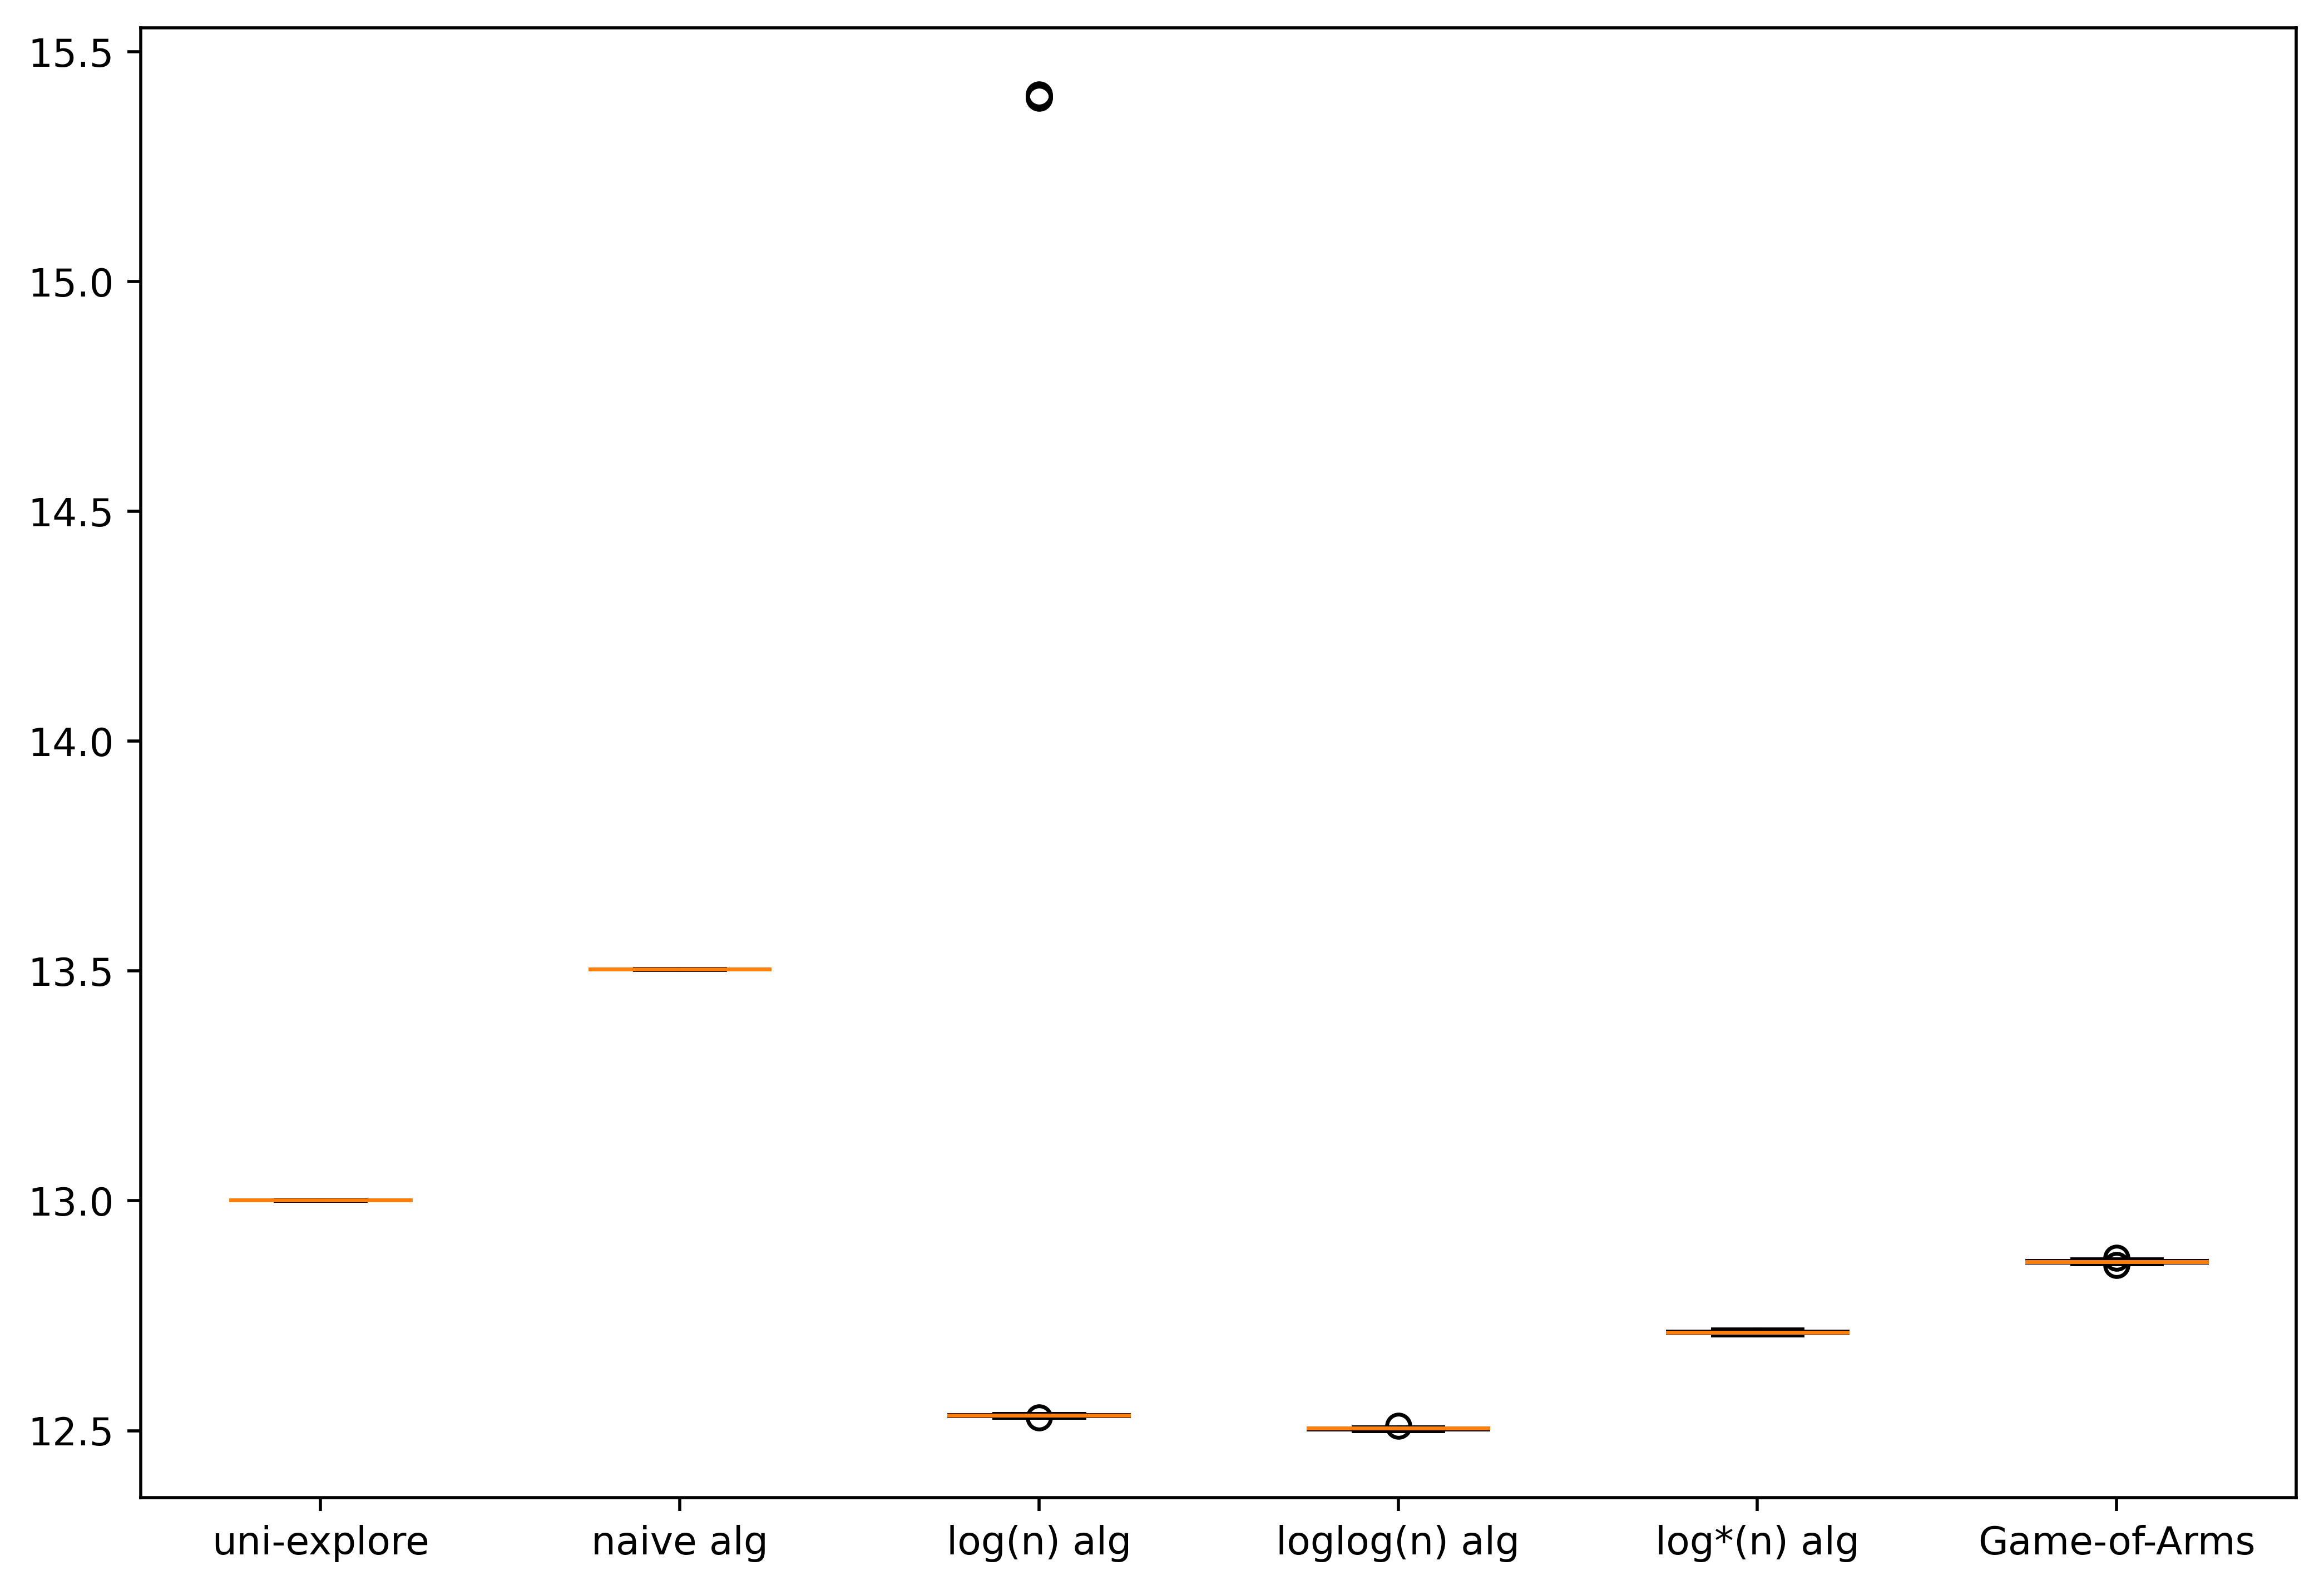

In [187]:
fig = plt.figure(figsize =(10, 7), dpi=500)

# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
ax = fig.add_subplot(111)

# Creating plot
bp = ax.boxplot(plot_data_log, patch_artist = True, autorange=True)

colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF', 
          '#00FFFF', '#F0000F']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(['uni-explore', 'naive alg', 'log(n) alg', 
                    'loglog(n) alg', 'log*(n) alg', 'Game-of-Arms'])
# show plot
plt.show()

## Below codes are for single-trial simulations

In [382]:
streaming_arm_buffer.reset()
uni_best_arm, uni_arm_ind, uni_regret = uniform_exploration_algorithm(streaming_arm_buffer, num_trials)

Processing arm number 5000..

In [383]:
streaming_arm_buffer.reset()
eps_naive_best_arm, eps_naive_arm_ind, eps_naive_regret = naive_eps_best_algorithm(streaming_arm_buffer, num_trials)

Processing arm number 5000..

In [384]:
streaming_arm_buffer.reset()
eps_log_best_arm, eps_log_arm_ind, eps_log_regret = log_eps_best_algorithm(streaming_arm_buffer, num_trials) 

Processing arm number 143..

Processing arm number 4546..

In [385]:
streaming_arm_buffer.reset()
eps_loglog_best_arm, eps_loglog_arm_ind, eps_loglog_regret = loglog_eps_best_algorithm(streaming_arm_buffer, 
                                                                                       num_trials) 

Processing arm number 4546..

In [386]:
streaming_arm_buffer.reset()
eps_logstar_best_arm, eps_logstar_arm_ind, eps_logstar_regret = logstar_eps_best_algorithm(streaming_arm_buffer, 
                                                                                           num_trials)

Processing arm number 4001..

In [387]:
streaming_arm_buffer.reset()
eps_goa_best_arm, eps_goa_arm_ind, eps_goa_regret = Game_of_Arms_regret_min(streaming_arm_buffer, num_trials)

Processing arm number 5000..

In [388]:
print('The regret obtained by uniform exploration is', uni_regret)
print('The regret obtained by the naive algorithm for eps-best arm is', eps_naive_regret)
print('The regret obtained by the log-space algorithm for eps-best arm is', eps_log_regret)
print('The regret obtained by the loglog-space algorithm for eps-best arm is', eps_loglog_regret)
print('The regret obtained by the logstar-space algorithm for eps-best arm is', eps_logstar_regret)
print('The regret obtained by the game-of-arm algorithm for eps-best arm is', eps_goa_regret)

The regret obtained by uniform exploration is 2409206826.788676
The regret obtained by the naive algorithm for eps-best arm is 805974761.074892
The regret obtained by the log-space algorithm for eps-best arm is 106932349.29968543
The regret obtained by the loglog-space algorithm for eps-best arm is 106864221.56502414
The regret obtained by the logstar-space algorithm for eps-best arm is 171916819.46136904
The regret obtained by the game-of-arm algorithm for eps-best arm is 249595655.25187328


In [349]:
eps_goa_best_arm.p

0.82

In [328]:
streaming_arm_buffer._best_index

660